In [6]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py

from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pqw

from functools import reduce
import operator
import gc

h = 0.6774
box_size = 205000

In [7]:
# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [8]:
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
from pyspark.sql.functions import broadcast, col, sqrt, pow, floor, monotonically_increasing_id, abs, pmod, least, row_number
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W

spark = SparkSession.builder \
    .appName("MyApp") \
    .master("spark://sohnic:7077") \
    .config("spark.driver.memory", "100g") \
    .getOrCreate()

sc = spark.sparkContext
sc.setCheckpointDir("hdfs://sohnic:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.hive.filesourcePartitionFileCacheSize", 524288000) # 500MB 

# 1. Reading the particle and subhalo data

In [21]:
%%time
#outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/snap099_sorted.parquet.snappy'
outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/snap099_cubic_indexed.parquet.snappy'

rawdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(outname)

CPU times: user 4.07 ms, sys: 0 ns, total: 4.07 ms
Wall time: 397 ms


In [20]:
##dividing the data into 100*100*100 boxes and adding the column for the box id
#rawdf = rawdf.withColumn("ix", floor(F.col("px") / (box_size/100) ).cast('int'))
#rawdf = rawdf.withColumn("iy", floor(F.col("py") / (box_size/100) ).cast('int'))
#rawdf = rawdf.withColumn("iz", floor(F.col("pz") / (box_size/100) ).cast('int'))
#
#outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/snap099_cubic_indexed.parquet.snappy'
#rawdf.write.option("compression", "snappy").mode("overwrite").save(outname)

In [22]:
rawdf.printSchema()

root
 |-- px: double (nullable = true)
 |-- py: double (nullable = true)
 |-- pz: double (nullable = true)
 |-- vx: double (nullable = true)
 |-- vy: double (nullable = true)
 |-- vz: double (nullable = true)
 |-- mass: double (nullable = true)
 |-- ix: integer (nullable = true)
 |-- iy: integer (nullable = true)
 |-- iz: integer (nullable = true)



In [23]:
%%time
rawdf.limit(4).toPandas().T

CPU times: user 23.7 ms, sys: 1.72 ms, total: 25.5 ms
Wall time: 6.74 s


0              1              2              3
px    136951.675173  136944.622136  136948.714682  136951.865350
py     29012.485050   29008.986187   29011.049563   29005.648173
pz     61114.726866   61091.393572   61101.947643   61099.191573
vx       818.147640     824.111000     705.680240     857.474100
vy      -137.449650    -137.423500    -331.828900     131.864090
vz       -66.318695      89.944695    -320.442200      46.966940
mass       0.000416       0.000497       0.000657       0.000355
ix        66.000000      66.000000      66.000000      66.000000
iy        14.000000      14.000000      14.000000      14.000000
iz        29.000000      29.000000      29.000000      29.000000

In [24]:
%%time
rawdf.describe().show() 

+-------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+------------------+
|summary|                px|                py|                pz|                vx|                vy|                  vz|                mass|                ix|                iy|                iz|
+-------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+------------------+
|  count|         711967480|         711967480|         711967480|         711967480|         711967480|           711967480|           711967480|         711967480|         711967480|         711967480|
|   mean|100688.61828005512| 99059.36895091024|105857.77590178407|1.2704478306707205| 1.088022603117185|-0.30910798969780295|5.280344892323588E-4| 48.61480849659032|47.819169449986674|

In [32]:
%%time
#counting the number of particles in each box
# Group by cubic indices (ix, iy, iz) and count the number of particles
counts_df = rawdf.groupBy("ix", "iy", "iz").agg(F.count("*").alias("particle_count"))

# Collect the results into pandas DataFrame for plotting
pandas_counts_df = counts_df.toPandas()

CPU times: user 20.2 ms, sys: 12.2 ms, total: 32.4 ms
Wall time: 857 ms


In [38]:
print(np.average(pandas_counts_df['particle_count']))

1648.4773578702182


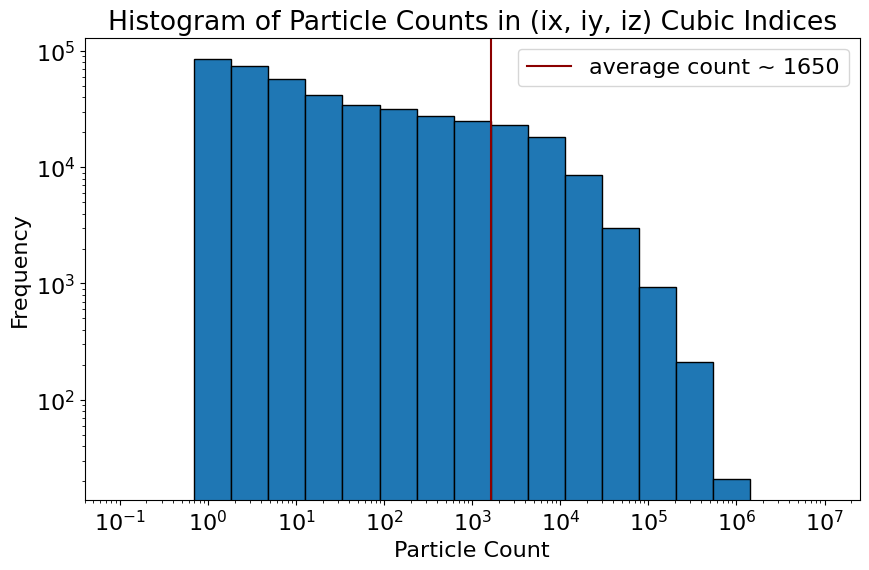

In [41]:
plt.figure(figsize=(10,6))
plt.hist(pandas_counts_df['particle_count'], bins=np.logspace(-1, 7, 20), edgecolor='black')
plt.axvline(x=np.average(pandas_counts_df['particle_count']), color = 'darkred',label = 'average count ~ 1650')
plt.title("Histogram of Particle Counts in (ix, iy, iz) Cubic Indices")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Particle Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [9]:
%%time
#subhalo table
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/subhalo_trim.parquet.snappy'
subdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(subname)

#adding a column for the subhalo id
#subdf = subdf.withColumn("sub_id", F.monotonically_increasing_id())
#windowSpec = W.orderBy("sub_id")
#subdf = subdf.withColumn("sub_id", F.row_number().over(windowSpec) - 1)

#changing the column name for cross joining
subdf = subdf.withColumnRenamed("px", "sub_px")
subdf = subdf.withColumnRenamed("py", "sub_py")
subdf = subdf.withColumnRenamed("pz", "sub_pz")
subdf = subdf.withColumnRenamed("vx", "sub_vx")
subdf = subdf.withColumnRenamed("vy", "sub_vy")
subdf = subdf.withColumnRenamed("vz", "sub_vz")
subdf = subdf.withColumnRenamed("mass", "sub_mass")

subdf.limit(4).toPandas()
#subdf.describe().toPandas().T 

CPU times: user 15.1 ms, sys: 0 ns, total: 15.1 ms
Wall time: 598 ms


sub_px         sub_py         sub_pz      sub_vx      sub_vy  \
0   85427.593750    2383.967529   55310.355469 -131.656403  479.287964   
1  187141.890625  113344.992188  185398.468750 -272.443634 -723.376648   
2  187014.406250  112437.914062  185575.781250  988.073975 -460.934631   
3  187099.734375  112477.179688  185824.390625  697.318298  -98.391518   

       sub_vz      sub_mass  sub_id  
0 -101.148598  1.035811e+09    2172  
1  126.204926  1.130842e+09    2173  
2  550.105957  1.118096e+09    2174  
3  102.688042  1.146507e+09    2175

In [5]:
#dividing the data into 100*100*100 boxes and adding the column for the box id
subdf = subdf.withColumn("sub_ix", floor(F.col("sub_px") / 100))
subdf = subdf.withColumn("sub_iy", floor(F.col("sub_py") / 100))
subdf = subdf.withColumn("sub_iz", floor(F.col("sub_pz") / 100))

subdf.toPandas().head()

sub_px         sub_py         sub_pz      sub_vx      sub_vy  \
0   99173.578125   40274.546875  107897.390625  -67.104362 -151.330200   
1  120705.281250   69941.101562  157908.031250  269.752045 -320.683807   
2  204545.296875  170294.812500   87957.867188  363.489685  148.479889   
3  173194.890625  158155.453125  162955.359375   83.774239 -126.974121   
4   34154.796875   35974.179688  149377.250000  559.149902  597.246765   

       sub_vz      sub_mass  sub_id  sub_ix  sub_iy  sub_iz  
0  167.907593  3.492153e+11  103713     991     402    1078  
1  128.344238  3.287442e+11  103714    1207     699    1579  
2  -54.548824  3.453248e+11  103715    2045    1702     879  
3  218.970139  3.937560e+11  103716    1731    1581    1629  
4 -471.297150  3.869574e+11  103717     341     359    1493

CPU times: user 21.2 ms, sys: 2.46 ms, total: 23.7 ms
Wall time: 2.58 s


px             py            pz         vx          vy  \
0  70037.914989  122711.870105  78395.454087 -115.07028 -183.363080   
1  70050.889402  122702.683213  78380.293789 -295.58307 -240.301150   
2  70052.049477  122687.959709  78388.525112 -357.15543 -156.076430   
3  70044.449632  122716.085783  78394.403400 -302.51917  -30.818964   

          vz      mass   ix    iy   iz  
0  164.85550  0.000487  700  1227  783  
1   57.16462  0.000680  700  1227  783  
2  215.15742  0.000389  700  1226  783  
3  586.60030  0.000632  700  1227  783

# 2. Saving the particle data within the 50kpc spheres centered at each subhalo

In [6]:
radius_sq = (50*h)**2
radius_sq

1147.1769

In [ ]:
radius_sq = (50*h)**2 #50kpc aperture size
id_size = 100 #number of boxes
box_size = 205000 #box size in the ckpc/h unit

#broad casting the subhalo table to the all workers
broadcast_subdf = F.broadcast(subdf)

# Step 1: Coarse filtering by grid indices considering the periodic boundary
filtered_df = rawdf.crossJoin(broadcast_subdf).filter(
    (F.least(F.abs(F.col("ix") - F.col("sub_ix")), id_size - F.abs(F.col("ix") - F.col("sub_ix")) ) <= 1) &
    (F.least(F.abs(F.col("iy") - F.col("sub_iy")), id_size - F.abs(F.col("iy") - F.col("sub_iy")) ) <= 1) &
    (F.least(F.abs(F.col("iz") - F.col("sub_iz")), id_size - F.abs(F.col("iz") - F.col("sub_iz")) ) <= 1)

filtered_df = filtered_df.withColumn("dist_cent_sq", F.pow(F.least(F.abs(F.col("px") - F.col("sub_px")), box_size - F.abs(F.col("px") - F.col("sub_px"))), 2) +
                                                     F.pow(F.least(F.abs(F.col("py") - F.col("sub_py")), box_size - F.abs(F.col("py") - F.col("sub_py"))), 2) +
                                                     F.pow(F.least(F.abs(F.col("pz") - F.col("sub_pz")), box_size - F.abs(F.col("pz") - F.col("sub_pz"))), 2))

# Step 2: Fine filtering by distance calculation considering the periodic boundary
filtered_df = filtered_df.filter(
    (F.col("dist_cent_sq")) < radius_sq
)

# Select relevant columns (including subhalo_id for identification)
result_df = filtered_df.select("sub_id", "px", "py", "pz", "vx", "vy", "vz", "mass", "dist_cent_sq")

subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/extracted_region_240918.parquet.snappy'
result_df.write.option("compression", "snappy").mode("overwrite").partitionBy("sub_id").parquet(subname)

In [7]:
#Checking the data
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/extracted_region_240918.parquet.snappy'
df = spark.read.parquet(subname)

df_filtered = df.filter(df.sub_id == 10000)
df_filtered.describe().toPandas()

summary                  px                  py                  pz  \
0   count                 160                 160                 160   
1    mean   86539.98217092815   115001.8123021865  144899.63376864442   
2  stddev  4.3586223280873195   3.330779277000689   4.676035647780895   
3     min   86517.54089495828  114987.06916561146  144874.48056289784   
4     max   86558.38979516154   115009.8895705654  144911.07695180256   

                    vx                  vy                  vz  \
0                  160                 160                 160   
1  -173.17213001875004  -162.7695493062501  201.53382877500002   
2   39.405089898886125   39.32917348856376   38.71986463333312   
3           -298.88245          -250.64078           100.80679   
4             -54.3939            -47.9957            280.2506   

                    mass        dist_cent_sq   sub_id  
0                    160                 160      160  
1   5.594609641875001E-4  52.507032744363826  10000.0  
2  1.4510780084495814E-4  133.96340006846228      0.0  
3           2.5858832E-4  0.3857580077748698    10000  
4           8.7464123E-4  1050.5479423833408    10000

# 3. Calculating stellar velocity dispersion

We measure the stellar velocity dispersion of ~10$^5$ subhalos. We first select stellar particles within subhalo-centered spheres with a certain radius. We then calculate the mass-weighted stellar velocity dispersion based on the 3D velocity of selected stellar particles. 

### $M = \Sigma m_i $
### $\overline{v_x} = \frac{\Sigma m_i v_{i,x}}{M}$, $\, \overline{v_y} = \frac{\Sigma m_i v_{i,y}}{M}$, $\, \overline{v_z} = \frac{\Sigma m_i v_{i,z}}{M}$ 
### $\sigma_x^2 = \frac{\Sigma m_i (v_{i,x} - \overline{v_{x}})^2}{M}$, $\, \sigma_y^2 = \frac{\Sigma m_i (v_{i,y} - \overline{v_{y}})^2}{M}$, $\, \sigma_z^2 = \frac{\Sigma m_i (v_{i,z} - \overline{v_{z}})^2}{M}$
### $\therefore \sigma_{3D} = \sqrt{\sigma_x^2 + \sigma_y^2 + \sigma_z^2}$
We repeat the above calculation for six different radii (3, 5, 10, 20, 30, and 50 kpc).

In [4]:
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/extracted_region_240918.parquet.snappy'

df = spark.read.parquet(subname)

df_filtered = df.filter(df.sub_id == 0)
df_filtered.describe().toPandas()

24/09/19 21:48:45 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


summary                  px                  py                  pz  \
0   count                 140                 140                 140   
1    mean  41840.652056403436  49050.240491958146  146618.59384127078   
2  stddev   3.434179745897391   2.646253888959987  3.8308437191442546   
3     min   41821.05056670708   49042.46942823968  146605.40289966715   
4     max   41854.11205584526   49061.58165936835  146634.89777236278   

                  vx                  vy                  vz  \
0                140                 140                 140   
1  491.1804762142857  2141.1263542857128  -734.4352684999993   
2  47.42457028605087   43.16277394559926   46.21973330251511   
3          330.69318           2015.9958          -865.76483   
4           636.5443           2252.1292          -622.19794   

                    mass          dist_cent_sq sub_id  
0                    140                   140    140  
1   5.289361012142856E-4    33.778025427646135    0.0  
2  1.3347494347952017E-4     69.45086123003283    0.0  
3           2.9745823E-4  2.034020586918334E-7      0  
4           8.7916595E-4    445.53822808873207      0

In [5]:
subhalo_count = df.select("sub_id").distinct().count()
print(f"Number of distinct subhalo IDs: {subhalo_count}")

Number of distinct subhalo IDs: 104290


In [6]:
%%time
from pyspark.sql import Window as W
import pyspark.sql.functions as F

# Define subhalo window for partitioning by "sub_id"
subhalo_window = W.partitionBy("sub_id")

# Initial weighted velocity and dispersion calculations for all particles
df = df.withColumn("vx_weighted", F.col("mass") * F.col("vx"))
df = df.withColumn("vy_weighted", F.col("mass") * F.col("vy"))
df = df.withColumn("vz_weighted", F.col("mass") * F.col("vz"))

df = df.withColumn("mass_sum", F.sum("mass").over(subhalo_window))

df = df.withColumn("vx_avg", F.sum("vx_weighted").over(subhalo_window) / F.col("mass_sum"))
df = df.withColumn("vy_avg", F.sum("vy_weighted").over(subhalo_window) / F.col("mass_sum"))
df = df.withColumn("vz_avg", F.sum("vz_weighted").over(subhalo_window) / F.col("mass_sum"))

df = df.withColumn("vx_disp", (F.col("vx") - F.col("vx_avg"))**2)
df = df.withColumn("vy_disp", (F.col("vy") - F.col("vy_avg"))**2)
df = df.withColumn("vz_disp", (F.col("vz") - F.col("vz_avg"))**2)

df = df.withColumn("dispersion_weighted", F.col("mass") * (F.col("vx_disp") + F.col("vy_disp") + F.col("vz_disp")))

# First aperture (50 kpc)
velocity_dispersion_df = df.groupBy("sub_id").agg(
    (F.sqrt(F.sum("dispersion_weighted") / F.sum("mass"))).alias("mass_weighted_velocity_dispersion_50")
)

# Iterate through different apertures (30, 20, 10, 5, 3 kpc)
for apert in [30, 20, 10, 5, 3]:
    # Reset the DataFrame for each aperture
    distance_limit = (apert * h) ** 2
    df_aperture = df.filter(F.col("dist_cent_sq") <= distance_limit)

    df_aperture = df_aperture.withColumn("mass_sum", F.sum("mass").over(subhalo_window))
    
    df_aperture = df_aperture.withColumn("vx_avg", F.sum("vx_weighted").over(subhalo_window) / F.col("mass_sum"))
    df_aperture = df_aperture.withColumn("vy_avg", F.sum("vy_weighted").over(subhalo_window) / F.col("mass_sum"))
    df_aperture = df_aperture.withColumn("vz_avg", F.sum("vz_weighted").over(subhalo_window) / F.col("mass_sum"))
    
    df_aperture = df_aperture.withColumn("vx_disp", (F.col("vx") - F.col("vx_avg"))**2)
    df_aperture = df_aperture.withColumn("vy_disp", (F.col("vy") - F.col("vy_avg"))**2)
    df_aperture = df_aperture.withColumn("vz_disp", (F.col("vz") - F.col("vz_avg"))**2)
    
    df_aperture = df_aperture.withColumn("dispersion_weighted", F.col("mass") * (F.col("vx_disp") + F.col("vy_disp") + F.col("vz_disp")))

    velocity_dispersion_tmp = df_aperture.groupBy("sub_id").agg(
        (F.sqrt(F.sum("dispersion_weighted") / F.sum("mass"))).alias("mass_weighted_velocity_dispersion_" + str(apert))
    )
    
    # Combine the results for each aperture
    velocity_dispersion_df = velocity_dispersion_df.join(velocity_dispersion_tmp, "sub_id")

# Show the final combined DataFrame
velocity_dispersion_df.show()

+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
|sub_id|mass_weighted_velocity_dispersion_50|mass_weighted_velocity_dispersion_30|mass_weighted_velocity_dispersion_20|mass_weighted_velocity_dispersion_10|mass_weighted_velocity_dispersion_5|mass_weighted_velocity_dispersion_3|
+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
|   148|                  60.353250511042376|                   61.38776748254439|                   62.38146856184683|                   65.64963521122424|                  70.08732553224418|                  68.72902382988421|
|   463|                   350.0666538753183|                   174.3795225514606|  

In [8]:
sub_id_to_find = 10000
filtered_df = velocity_dispersion_df.filter(velocity_dispersion_df["sub_id"] == sub_id_to_find)
filtered_df.show()

+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
|sub_id|mass_weighted_velocity_dispersion_50|mass_weighted_velocity_dispersion_30|mass_weighted_velocity_dispersion_20|mass_weighted_velocity_dispersion_10|mass_weighted_velocity_dispersion_5|mass_weighted_velocity_dispersion_3|
+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
| 10000|                   67.54407056722899|                   67.25768361639068|                   67.79019897412951|                   68.88366311763865|                  72.93970174994601|                  73.40487757132327|
+------+------------------------------------+------------------------------------+--

In [9]:
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/vdisp_240918_snappy.parquet'
velocity_dispersion_df.write.mode("overwrite").parquet(subname, compression="snappy")

24/09/19 21:56:56 WARN TaskSetManager: Lost task 28.0 in stage 72.0 (TID 140423) (192.168.0.132 executor 7): java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillReader.<init>(UnsafeSorterSpillReader.java:50)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillWriter.getReader(UnsafeSorterSpillWriter.java:159)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.getSortedIterator(UnsafeExternalSorter.java:555)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:172)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.window.WindowExec$$anon$1.fetchNextRow(Windo

Py4JJavaError: An error occurred while calling o481.parquet.
: org.apache.spark.SparkException: Job aborted due to stage failure: ResultStage 72 (parquet at NativeMethodAccessorImpl.java:0) has failed the maximum allowable number of times: 4. Most recent failure reason:
org.apache.spark.shuffle.FetchFailedException: Error in reading FileSegmentManagedBuffer[file=/tmp/spark-b42d301b-d18d-461a-ab35-082de6c55ddf/executor-8c095244-f677-4236-97d1-fd2df17a7fea/blockmgr-daa2c3ed-6e40-4748-b072-b4488231ec77/19/shuffle_21_85348_0.data,offset=293333,length=26503]
	at org.apache.spark.errors.SparkCoreErrors$.fetchFailedError(SparkCoreErrors.scala:437)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1232)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:890)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:86)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Iterator$$anon$10.nextCur(Iterator.scala:587)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:601)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:576)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:31)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:576)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.window.WindowExec$$anon$1.fetchNextRow(WindowExec.scala:118)
	at org.apache.spark.sql.execution.window.WindowExec$$anon$1.<init>(WindowExec.scala:127)
	at org.apache.spark.sql.execution.window.WindowExec.$anonfun$doExecute$3(WindowExec.scala:107)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.ZippedPartitionsRDD2.compute(ZippedPartitionsRDD.scala:89)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.ZippedPartitionsRDD2.compute(ZippedPartitionsRDD.scala:89)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.ZippedPartitionsRDD2.compute(ZippedPartitionsRDD.scala:89)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.ZippedPartitionsRDD2.compute(ZippedPartitionsRDD.scala:89)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.ZippedPartitionsRDD2.compute(ZippedPartitionsRDD.scala:89)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.io.IOException: Error in reading FileSegmentManagedBuffer[file=/tmp/spark-b42d301b-d18d-461a-ab35-082de6c55ddf/executor-8c095244-f677-4236-97d1-fd2df17a7fea/blockmgr-daa2c3ed-6e40-4748-b072-b4488231ec77/19/shuffle_21_85348_0.data,offset=293333,length=26503]
	at org.apache.spark.network.buffer.FileSegmentManagedBuffer.createInputStream(FileSegmentManagedBuffer.java:112)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:863)
	... 65 more
Caused by: java.io.FileNotFoundException: /tmp/spark-b42d301b-d18d-461a-ab35-082de6c55ddf/executor-8c095244-f677-4236-97d1-fd2df17a7fea/blockmgr-daa2c3ed-6e40-4748-b072-b4488231ec77/19/shuffle_21_85348_0.data (No such file or directory)
	at java.base/java.io.FileInputStream.open0(Native Method)
	at java.base/java.io.FileInputStream.open(FileInputStream.java:219)
	at java.base/java.io.FileInputStream.<init>(FileInputStream.java:157)
	at org.apache.spark.network.buffer.FileSegmentManagedBuffer.createInputStream(FileSegmentManagedBuffer.java:101)
	... 66 more

	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.immutable.List.foreach(List.scala:333)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:1961)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2978)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeWrite$4(FileFormatWriter.scala:307)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:271)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:304)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:190)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:190)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:354)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:382)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:354)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:104)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:488)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:133)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:856)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:387)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:360)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:789)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


24/09/19 22:01:39 WARN TaskSetManager: Lost task 81.0 in stage 72.3 (TID 203967) (192.168.0.134 executor 14): FetchFailed(BlockManagerId(0, 192.168.0.138, 46871, None), shuffleId=21, mapIndex=394, mapId=184928, reduceId=81, message=
org.apache.spark.shuffle.FetchFailedException
	at org.apache.spark.errors.SparkCoreErrors$.fetchFailedError(SparkCoreErrors.scala:437)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1232)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:971)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:86)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Iterator$$anon$10.nextCur(Iterator.scala:587)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:601)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:576)
	at org.apache.spark.util.Com

In [17]:
df = spark.read.parquet(subname)

df_filtered = df.filter(df.sub_id == 0)
df_filtered.describe().toPandas()

#subhalo_count = df.select("sub_id").distinct().count()
#print(f"Number of distinct subhalo IDs: {subhalo_count}")

AnalysisException: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for Parquet. It must be specified manually.